<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/polyphonicBachLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generieren polyphoner Sequenzen

Im ersten Teil des Notebooks haben Sie gelernt, wie man mit rekurrenten neuronalen Netzen einfache Melodien generieren kann. Wir werden uns im zweiten Teil nun an polyphone Musik wagen. Im Prinzip funktioniert dies sehr ähnlich. Leider trifft aber hier auch wieder ein generelles Prinzip des maschinellen Lernens zu: Je interessanter die Problemstellung, desto größer die Fummelei, bis etwas Vernünftiges dabei heraus kommt.

Um den Rahmen des Kurses nicht zu sprengen, lernen wir also nicht den back-catalogue der westlichen Musikgeschichte, sondern tasten uns langsam heran. Dieses Mal vewenden wir als Traingsdatensatz vierstimmige Bachchoräle.

Viele der Code-Segmente sehen auf den ersten Blick sehr ähnlich aus wie im letzten Notebook. Wir werden deshalb lediglich die entscheidenden Unterschiede hervorheben.

Zunächst laden wir wieder die nötigen Bibliotheken und den Datensatz herunter.

### Allgemeine Vorbereitungen

In [1]:
!git clone https://github.com/jamesrobertlloyd/infinite-bach.git

fatal: destination path 'infinite-bach' already exists and is not an empty directory.


In [2]:
# Bibliotheken zum Lesen und Abspielen von Mididateien
%%capture
!apt install fluidsynth
!pip install midi2audio
!pip install pypianoroll

In [3]:
file_ID = "18_HRx9G7-IKlEBDguJam7EIfv0WvU67l"
filename = 'default_sound_font.sf2'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_ID}' -O {filename}
!mkdir ~/.fluidsynth
!mv default_sound_font.sf2 ~/.fluidsynth/default_sound_font.sf2

--2023-06-17 09:47:27--  https://docs.google.com/uc?export=download&id=18_HRx9G7-IKlEBDguJam7EIfv0WvU67l
Resolving docs.google.com (docs.google.com)... 142.251.172.100, 142.251.172.113, 142.251.172.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.172.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nj9rp9734hnbgq7r6gv67ks7v5fmb29u/1686995175000/02513860244246328249/*/18_HRx9G7-IKlEBDguJam7EIfv0WvU67l?e=download&uuid=d76c2f17-f77c-49ff-bbf9-5a19f791acde [following]
--2023-06-17 09:47:28--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nj9rp9734hnbgq7r6gv67ks7v5fmb29u/1686995175000/02513860244246328249/*/18_HRx9G7-IKlEBDguJam7EIfv0WvU67l?e=download&uuid=d76c2f17-f77c-49ff-bbf9-5a19f791acde
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 108.177.120.132, 2607:

In [4]:
import glob
import os
import pickle
from random import choice,shuffle
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio, clear_output

import pypianoroll
from midi2audio import FluidSynth

import keras
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dropout,Flatten,Dense
from keras.optimizers import Adam

In [5]:
mid_files = glob.glob('infinite-bach/**/*.mid',recursive = True)
print(len(mid_files))

499


### Vorbereitung der Daten

Um unser Netzwerk nicht zu überfordern, beschränken wir uns auf Choräle mit vier Stimmen. Dazu müssen wir zunächst jede Datei einmal öffnen und die Anzahl der Stimmen abfragen.

In [6]:
four_track = []
for mf in mid_files:
    try:
        pr = pypianoroll.read(mf)
        if len(pr.tracks)==4:
            four_track.append(mf)
    except:
        print(f'failed to read {mf}')

failed to read infinite-bach/source/output.mid


In [7]:
print(len(four_track))

387


Wir haben also immerhin noch 387 Dateien. Da wir nun nicht nur eine Stimme pro Beispiel laden wollen, muss die Datenlesefunktion abgeändert werden.

In [9]:
def generate_data_batch(N, seq_len, file_list, beat_resolution=2, random_transpose=False):
    """ generate batch of samples.
       x -> sequence, y -> next slice

       """
    X = []
    y = []
    while len(X) < N:
        try:
            mid_file = choice(file_list)
            ar = load_midi_to_array(mid_file,seq_len,beat_resolution)
        except:
            print(f"failed to read {mid_file}")
            continue
        if random_transpose:
            interval = np.random.randint(-12, 13)
            pr.transpose(interval)


        # take 100 samples from each file randomly
        for s in range(100):
            start = np.random.randint(0, ar.shape[0] - seq_len - 1)
            end = start + seq_len
            X.append(ar[start:end])  # turn so time is last dim
            y.append(ar[end])
            if len(X) == N:
                break

    X = np.array(X)
    y = np.array(y)

    order = np.arange(N)
    shuffle(order)

    return X[order], y[order]

def load_midi_to_array(mid_file,seq_len,beat_resolution):
    pr = pypianoroll.read(mid_file,resolution=beat_resolution)
    # wir addieren einfach die pianorolls der tracks
    ar = sum([track.pianoroll for track in pr.tracks])

    # drop leading or trailing zeros
    content = np.where(ar.sum(axis=1) > 0)[0]

    # now add leading zeros of window size
    ar = np.append(np.zeros((seq_len - 1, ar.shape[1])), ar, axis=0)

    # das Hinzufügen der Pausenspur können wir uns nun auch sparen
    # silence = ar.sum(axis=1)==0
    # ar = np.append(ar,silence[:,np.newaxis],axis=1)

    # binarize:
    ar = (ar > 0) * 1

    return ar

Wir schauen uns wieder ein Beispiel an:

Text(0.5, 0, 'time')

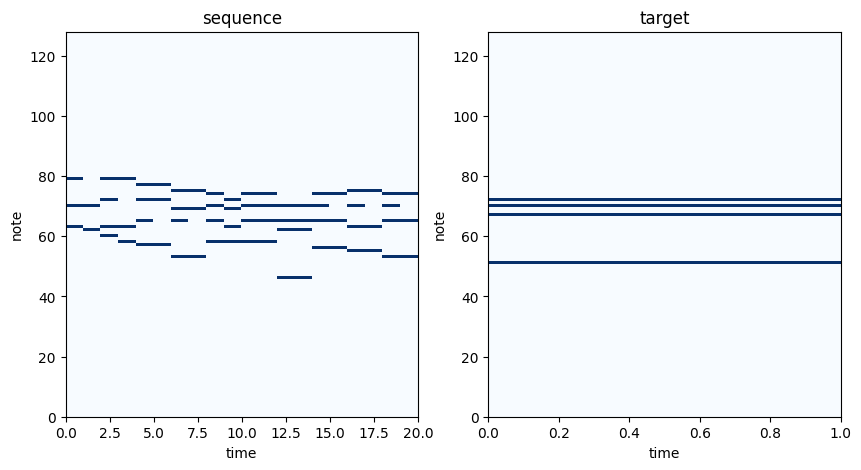

In [10]:
X,y = generate_data_batch(1,20,four_track)
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('sequence')
plt.pcolor(X[0].T, cmap='Blues')
plt.ylabel('note')
plt.xlabel('time')

plt.subplot(1,2,2)
plt.title('target')
plt.pcolor(y[[0]].T, cmap='Blues')
plt.ylabel('note')
plt.xlabel('time')

### Modelldefinition

Die Parametrisierung des Modells umfasst ähnliche Variablen wie im vorherigen Abschnitt. Wir wollen uns jedoch die Möglichkeit offen halten, eine weitere LSTM-Schicht einzufügen.

In [20]:
# parameters
N_train = 10000
N_test = 2000
beat_resolution = 2
seq_len = beat_resolution*16
n_channels = 128 # diesmal nur 128, alle midi-noten ohne silence
epochs = 100
batch_size = 64
dropout = 0.2
lstm_units = 128
lstm_layers = 2 # Anzahl der lstm-schichten

Außerdem müssen wir diesmal mit längeren Trainingszeiten rechnen. Damit nicht alles verloren geht, wenn die Session abstürzt, speichern wir Zwischenstände im Google Drive.

In [21]:
save_path = '/content/drive/My Drive/'
model_name = f'bach_poly_midi_net_{beat_resolution}_{seq_len}_{dropout}_{lstm_units}_{lstm_layers}'

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Die Zelle zur Modelldefinition wird dadurch verkompliziert, dass wir nun zuerst prüfen wollen, ob ein Modell mit den gleichen Parametern schon existiert.

Der entscheidende Unterschied liegt aber in der Aktivierungsfunktion der Output-Schicht. Beim monophonen Modell konnten wir die Softmax-Funktion benutzen, das immer genau eine Zelle aktiv sein sollte. Das ist übrigens auch der Grund, warum wir dort die *silence*-Spur benötigten.

Jetzt können bis zu vier Zellen gleichzeitig aktiv sein - oder keine. Dies kann durch die *Sigmoid*-Aktivierung erreicht werden. Zusätzlich können die Sigmoid-Units auch "silent" sein, so dass keine extra Spur hierfür notwendig ist.

In [23]:
try:  # es wird zunächst versucht, ein existierendes Modell zu laden
    model = load_model(os.path.join(save_path, model_name + ".h5"))
    histories = pickle.load(open(os.path.join(save_path, model_name + ".pkl"), "rb"))
    print(f"loaded {model_name}")
except:  # Falls das nicht klappt, muss eben ein neues erzeugt werden.
    print(f"creating new model")
    model = Sequential()
    if lstm_layers == 1:  # bei nur einer Schicht ist alles wie gehabt.
        model.add(
            LSTM(lstm_units, return_sequences=False, input_shape=(seq_len, n_channels))
        )
        model.add(Dropout(dropout))
    else:  # bei mehreren Schichten werden die vollständigen Sequenzen zurück gegeben.
        model.add(
            LSTM(lstm_units, return_sequences=True, input_shape=(seq_len, n_channels))
        )
        model.add(Dropout(dropout))
        for layer in range(1, lstm_layers - 1):  # ausser bei der letzten Schicht
            model.add(LSTM(lstm_units, return_sequences=True))
            model.add(Dropout(dropout))
        model.add(LSTM(lstm_units, return_sequences=False))
        model.add(Dropout(dropout))

    # am ende eine Ausgabeschicht mit 'sigmoid'-Aktivierung
    model.add(Flatten())
    model.add(Dense(n_channels, activation="sigmoid"))
    histories = []

creating new model


Als `loss`-verwenden wir nun die `binary_crossentropy`, welche zur Sigmoid-Aktivierung passt. Auch verwenden wir expliyit eine kleinere Lernrate.

In [24]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Wir unterteilen wieder die Dateien in Train- und Testsets.

In [25]:
shuffle(four_track)
train_ratio = 0.8
train_files = mid_files[:int(train_ratio*len(four_track))]
test_files = mid_files[int(train_ratio*len(four_track)):]

### Training

Das Training beginnt. Zusätzlich zu dem Loop, den Sie schon kennen kommen nun noch zwei Zeilen zum Speichern. Neben dem Modell werden auch die *history*-Listen gespeichert.

In [26]:
while len(histories) < epochs:
    print(f"epoch {len(histories)+1} of {epochs}")
    X_train, y_train = generate_data_batch(
        N_train, seq_len, train_files, beat_resolution=beat_resolution
    )
    X_test, y_test = generate_data_batch(
        N_test, seq_len, test_files, beat_resolution=beat_resolution
    )
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(X_test, y_test),
    )
    histories.append(history.history)
    model.save(os.path.join(save_path, model_name + ".h5"))
    pickle.dump(histories, open(os.path.join(save_path, model_name + ".pkl"), "wb"))

epoch 1 of 100
157/157 [==============================] - 6s 17ms/step - loss: 0.3916 - accuracy: 0.0106 - val_loss: 0.1408 - val_accuracy: 0.0000e+00
epoch 2 of 100
157/157 [==============================] - 2s 10ms/step - loss: 0.1199 - accuracy: 0.0130 - val_loss: 0.0970 - val_accuracy: 0.0100
epoch 3 of 100
157/157 [==============================] - 2s 11ms/step - loss: 0.0951 - accuracy: 0.0165 - val_loss: 0.0901 - val_accuracy: 0.0120
epoch 4 of 100
157/157 [==============================] - 2s 10ms/step - loss: 0.0886 - accuracy: 0.0177 - val_loss: 0.0819 - val_accuracy: 0.0265
epoch 5 of 100
157/157 [==============================] - 2s 10ms/step - loss: 0.0845 - accuracy: 0.0173 - val_loss: 0.0821 - val_accuracy: 0.0150
epoch 6 of 100
157/157 [==============================] - 2s 11ms/step - loss: 0.0825 - accuracy: 0.0143 - val_loss: 0.0791 - val_accuracy: 0.0035
epoch 7 of 100
157/157 [==============================] - 2s 10ms/step - loss: 0.0813 - accuracy: 0.0164 - val_los

Wir lassen auch hier wieder nach einigen Iterationen den Fehlerverlauf anzeigen.

Text(0.5, 0, 'epoch')

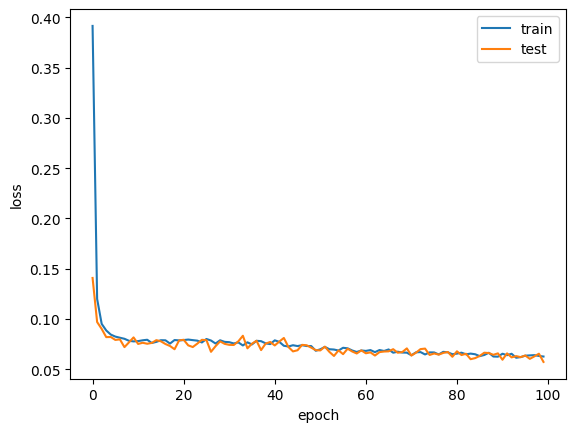

In [27]:
loss = []
val_loss = []
for history in histories:
    loss.append(history['loss'])
    val_loss.append(history['val_loss'])

plt.plot(loss,label = 'train')
plt.plot(val_loss,label = 'test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

### Erzeugen von künstlichen Sequenzen

Zum Generieren müssen wir auch hier wieder etwas Zufall untermischen, um interessante Ergebnisse zu erhalten. Dieses mal wollen wir jedoch nicht nur einen Wert ziehen, sondern das Netzwerk soll entscheiden, wie viele Töne es spielt.

Wir benutzen wieder die Temperaturanalogie zum Glätten der Verteilung. Zusätzlich müssen wir nun aber für jeden Ton eine Zufallszahl ziehen und sie mit der Wahrscheinlichkeit für diesen Kanal vergleichen. Um etwas mehr Kontrolle zu behalten, führen wir einen weiteren Parameter names `business` ein. Dieser bestimmt, ob eher viele oder eher weniger Töne gespielt werden sollen.

In [51]:
def heat_distribution(distr, temperature=1.0):
    distr = np.asarray(distr).astype("float64")
    distr = np.log(distr) / temperature
    exp_distr = np.exp(distr)
    distr = exp_distr / np.sum(exp_distr)
    return distr / distr.sum()

def temperature_sample(preds, temperature=1.0, business=1,top_percent = 100):
    # mehrere Werte können gezogen werden.
    probas = heat_distribution(preds, temperature)
    # die prozentzahl der infrage kommenden werte
    order = np.argsort(probas)
    n_keep = int(top_percent/100.*len(order))
    # alle anderen werden auf 0 gesetzt
    drop = order[:-n_keep]
    probas[drop] = 0
    return (probas > np.random.rand(*probas.shape) / business) * 1

In [52]:
def generate(
    model,
    seed,
    n_steps=100,
    beat_resolution=beat_resolution,
    temperature=1.0,
    business=1.0,
    top_percent = 20
):
    # ein array für den gesamten output
    generated = np.append(
        seed, np.zeros((n_steps, seed.shape[1]), dtype=seed.dtype), axis=0
    )[np.newaxis, :, :]
    # wir sammeln die predictions in einer liste
    preds = []
    for i in range(n_steps):
        # das Modell bekommt die letzten Schritte als Input
        model_input = generated[:, i : i + seed.shape[0]]
        prediction = model.predict(model_input).squeeze()
        preds.append(prediction)
        # die Note mit der maximalen Wahrscheinlichkeit gewinnt.
        notes = temperature_sample(prediction, temperature, business,top_percent)
        # und wird in den Array eingetragen
        generated[:, i + seed.shape[0], :] = notes

    # der array wird nun von überflüssigen dimensionen befreit
    generated = generated.squeeze()
    # und stille am anfang abgeschnitten
    gsum = generated.sum(axis=1)
    first = np.where(gsum > 0)[0][0]
    generated = generated[first:]
    # das Ergebnis wird wieder in ein pianoroll-objekt umgewandelt
    tr = pypianoroll.StandardTrack(pianoroll=generated * 100)
    mt = pypianoroll.Multitrack(tracks=[tr],resolution=beat_resolution)
    return mt, np.array(preds)


In [53]:
X_test, y_test = generate_data_batch(
        N_test, seq_len, test_files, beat_resolution=beat_resolution)

In [54]:
params = {
    'model': model,
    'seed': X_test[4],  # choice(X_test)  # das Ausgangsmuster
    'n_steps': 32,
    'temperature': 1.,
    'business': 2.,
}
output, preds = generate(**params)

1/1 [==============================] - 0s 21ms/step


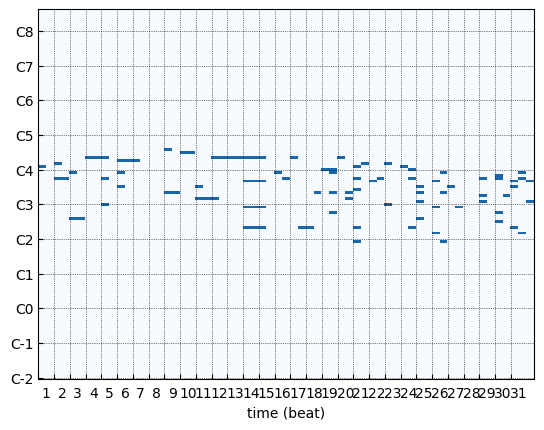

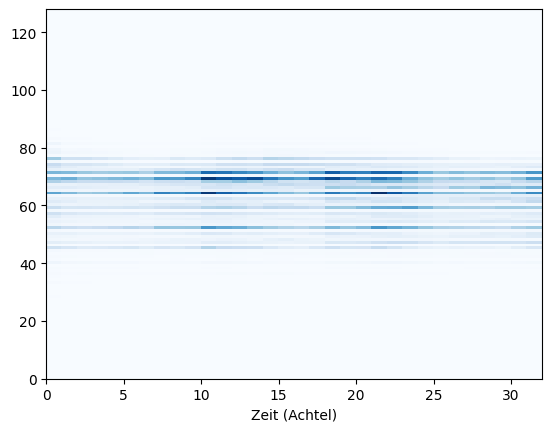

In [55]:
pypianoroll.plot(output, label="x")
output.write("output.mid")
plt.figure()
plt.pcolor(preds.T, cmap="Blues")
_ = plt.xlabel("Zeit (Achtel)")

In [56]:
FluidSynth().midi_to_audio('output.mid', 'output.wav')
Audio(filename = 'output.wav')

Es ist nicht schwer zu erkennen, bis zu welchem Punkt die urpsrüngliche Komposition geht, und ab wann die Ausgabe des Netzwerks beginnt. Doch obwohl es etwas wirr klingt, ist es auch nicht komplett zufällig und besitzt schon wiedererkennbare Strukturen aus den Inputdaten.

### Aufgabe: Experimentieren

Probieren Sie etwas herum. Können Sie durch andere Parameterwerte (`temperature`, `business`) beim Generieren *bessere* Ergebnisse erzielen?

Würde das Netzwerk von mehr Training profitieren? Ist Overfitting in diesem Fall vielleicht sogar wünschenswert? *Overfitted* ein menschlicher Klavierschüler, der einige Stücke auswendig kann und dann zu improvisieren anfängt, nicht auch?

Vielleicht sollte das Modell komplexer oder weniger komplex sein (Anzahl der Units, layers)? Oder sollten zusätzliche Trainingsbeispiele erzeugt werden, indem die vorhandenen Stücke transponiert werden (Parameter `random_transpose` in `generate_data_batch`)?

Wir hoffen, dass wir Ihren Spieltrieb geweckt haben, und wünschen Ihnen viel Spaß beim Experimentieren!

Lassen Sie Ihrer Fantasie freien Lauf!

In [ ]:
# Lösung